In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [3]:
f = lambda x: 1.35**x

xlim = 20
n_samples = 100         # astype('f') required for TensorFlow to prevent "TypeError: Input 'b' of 'MatMul'
truex = np.linspace(-xlim, xlim, n_samples).astype('f')  #  Op has type float32 that does not match type float64
truey = [f(_) for _ in truex]
rands = np.random.randn(n_samples).astype('f')          #  of argument 'a'." error

# this is a problem because consecutive batches aren't sampled similarly, so the cost doesn't converge
# in each consecutive batch
#randy = [exp(v + rands[i]) for i, v in enumerate(truex)]
shufx = np.copy(truex)
np.random.shuffle(shufx)
shufrandy = [f(v + rands[i]) for i, v in enumerate(shufx)]
shufrande = [f(v + rands[i]) - f(v) for i, v in enumerate(shufx)]

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix', 'text.usetex': False})

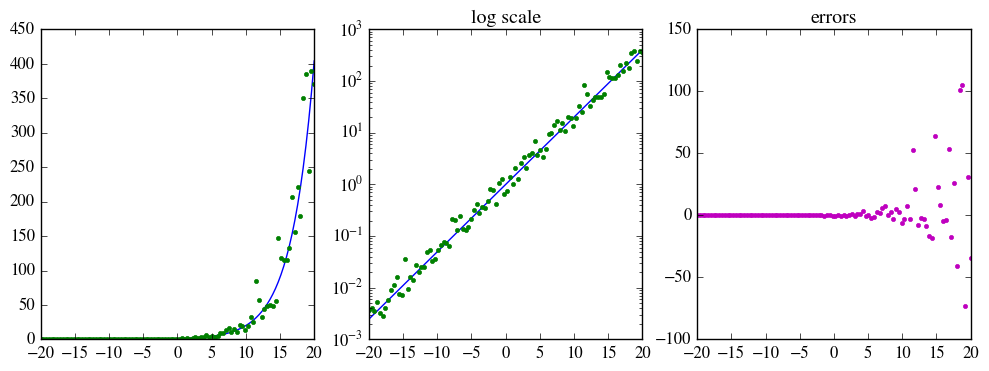

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(truex, truey)
#ax[0].set_xlim(-xlim/4, xlim/4); ax[0].set_ylim(0, xlim*5); ax[0].grid(True)
ax[0].plot(shufx, shufrandy, 'g.')

ax[1].set_title('log scale')
ax[1].plot(truex, truey)
#ax[1].grid(True) #ax[1].set_xlim(-xlim/4, xlim/4); ax[1].set_ylim(0, xlim*5); 
ax[1].plot(shufx, shufrandy, 'g.')
ax[1].set_yscale("log")

ax[2].set_title('errors')
ax[2].plot(shufx, shufrande, 'm.');

In [5]:
import tensorflow as tf

In [6]:
# Parameters
learning_rate = 0.05
training_epochs = 500
batch_size = 10
display_step = training_epochs / 10

# Network Parameters
n_hidden_1 = 7 # 1st layer number of features (see note below)
n_hidden_2 = n_hidden_1 # 3 # 2nd layer number of features
n_input = 1 # value of X
n_output = 1 # value of Y

In [7]:
# Create model (https://wookayin.github.io/TensorflowKR-2016-talk-debugging/#15)
def multilayer_perceptron(input_layer, weights, biases):
    hidden_1 = tf.nn.relu(tf.matmul(input_layer, weights['h1'] ) + biases['b1'] )
    hidden_2 = tf.nn.relu(tf.matmul( hidden_1  , weights['h2'] ) + biases['b2'] )
    return                tf.matmul( hidden_2  , weights['out']) + biases['out']


In [8]:
# Store layers weight & bias
def construct_weights_biases(divisor=1):
    '''divisor allows for fewer degrees of freedom when predicting errors'''
    nh1 = int(n_hidden_1 / divisor)
    nh2 = int(n_hidden_2 / divisor)
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, nh1])),
        'h2': tf.Variable(tf.random_normal([nh1, nh2])),
        'out': tf.Variable(tf.random_normal([nh2, n_output]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([nh1])),
        'b2': tf.Variable(tf.random_normal([nh2])),
        'out': tf.Variable(tf.random_normal([n_output]))
    }
    return (weights, biases)

# Construct model w/ input/output placeholders
x = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])
y_pred = multilayer_perceptron(x, *construct_weights_biases()) # the model, y predictions
y_cost = tf.pow(y_pred - y, 2)
y_pred_err = y_cost # tf.log(y_cost) # tf.abs(y_pred - y) # log works great b/c then no need to complicate e_pred

# try fitting errors with an exponential curve, if they fit, then it will be helpful, if they
# don't, then it won't matter b/c either it'll be a normal distribution (great!) or uniform (no fit--also great!)
b0 = tf.Variable(np.random.randn())
b1 = tf.Variable(np.random.randn())
b2 = tf.Variable(np.random.randn())
b3 = tf.Variable(np.random.randn())
#e_pred = tf.add(tf.add(b0, tf.mul(b1, x)), tf.mul(b2, tf.pow(x, 2)))
e_pred = b0 + b1*x + b2*x*x + b3*x*x*x
#e_pred = multilayer_perceptron(x, *construct_weights_biases(divisor=1)) # error predictions (fewer deg of freedom)
e_cost = tf.sqrt(tf.abs(e_pred - y_pred_err)) # tf.pow(e_pred - y_pred_err, 2) # 

# components of the cost function
cost_raw  = tf.reduce_sum(y_cost)
#cost_norm = tf.reduce_sum(tf.div(y_cost, tf.exp(e_pred)))
#cost_norm = tf.reduce_sum(tf.div(y_cost, tf.maximum(1.0, tf.exp(e_pred)))) # dividing by exp ensures a positive divisor.
cost_norm = tf.reduce_sum(tf.div(y_cost, tf.sqrt(tf.maximum(1.0, e_pred)))) # but we're dividing then by a really big #.
cost_err  = tf.reduce_sum(e_cost)                 # and don't we still need to divide the xs also?



# or just use clipping :(

# the nice (?) thing about these approaches is that they are random, so
# (1) lots of different models can be generated but
# (2) there's really no understanding regarding why one might be better than another
# back to conformal prediction and bayesian approaches (ML and stats) i suppose


    
# Define loss and optimizer (https://www.tensorflow.org/api_docs/python/nn/)
# for heteroskedastic functions, first learn the shape of the error/cost/loss, then learn the actual
# function of interest with a cost function that is normalized for the heteroskedasticity of the data
# similar to this: https://en.wikipedia.org/wiki/AdaBoost
cost = cost_norm + cost_err

# Optimizer overview: http://sebastianruder.com/optimizing-gradient-descent/
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [9]:
pys = []
pes = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        epoch_cost = 0.
        n_batches = int(n_samples / batch_size)
        
        # Loop over all batches
        for i in range(n_batches):
            bbegin = i * batch_size
            bend = min((i+1) * batch_size, n_samples)
            batch_x = np.array(    shufx[bbegin:bend]).reshape((bend - bbegin, 1))
            batch_y = np.array(shufrandy[bbegin:bend]).reshape((bend - bbegin, 1))

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, yout, eout, cr, cn, ce = (
                sess.run([optimizer, cost, y_pred, e_pred, cost_raw, cost_norm, cost_err],
                         feed_dict={x: batch_x, y: batch_y}))
            
            # compute average loss (note using reduce_sum, not reduce_avg, above)
            epoch_cost += c
            
            if epoch == 0 or epoch == training_epochs-1:
                print('  Batch: c={:10.1f}, cr={:8.1f}, cn={:8.1f}, ce={:8.1f}, log10(ce/cn)={:8.2f}'.format(c, cr, cn, ce, log10(ce/cn)))

            # debugging/printing output
            if epoch == 0 or epoch == training_epochs-1:
            
                # print last batch's costs
                if bbegin == 0:
                    batchout = []
                    for i in range(bend - bbegin):
                        xi = batch_x[i].reshape(1, 1)
                        yi = batch_y[i].reshape(1, 1)
                        ci, youti, eouti, cri, cni, cei = (
                            sess.run([cost, y_pred, e_pred, cost_raw, cost_norm, cost_err],
                                     feed_dict={x: xi, y: yi}))
                        batchout.append((batch_x[i,0], batch_y[i,0], youti[0,0], f(batch_x[i,0]), eouti[0,0], ci, cri, cni, cei))
                    for bo in sorted(batchout):
                        print('    Point: Loss(x={:5.1f}, y={:5.1f}, py={:5.1f}, ty={:5.1f}, pe={:7.1f}) = {:6.1f} {:6.1f} {:6.1f} {:6.1f}'.format(*bo))
                    
            # save final predictions for plotting
            if epoch == training_epochs-1:
                for v in yout: pys.append(v)
                for v in eout: pes.append(v)
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print('Epoch: {:4d}'.format(epoch+1), "cost=", "{:.9f}".format(epoch_cost / n_samples))
            
    print("Optimization Finished!")

  Batch: c=    1587.0, cr= 71352.1, cn=   992.6, ce=   594.5, log10(ce/cn)=   -0.22
    Point: Loss(x=-18.4, y=  0.0, py=  3.0, ty=  0.0, pe=-7844.7) =   97.3    8.7    8.7   88.6
    Point: Loss(x=-17.2, y=  0.0, py=  3.1, ty=  0.0, pe=-6359.3) =   89.2    9.4    9.4   79.8
    Point: Loss(x=-11.1, y=  0.1, py=  3.5, ty=  0.0, pe=-1648.9) =   52.3   11.6   11.6   40.7
    Point: Loss(x=-10.3, y=  0.0, py=  3.5, ty=  0.0, pe=-1301.9) =   48.3   12.0   12.0   36.2
    Point: Loss(x= -3.0, y=  0.4, py=  3.1, ty=  0.4, pe=  -23.2) =   12.8    7.3    7.3    5.5
    Point: Loss(x=  2.2, y=  2.6, py=  4.6, ty=  1.9, pe=   29.1) =    5.7    3.8    0.7    5.0
    Point: Loss(x=  7.1, y= 14.1, py= 38.2, ty=  8.3, pe=  586.7) =   25.9  583.5   24.1    1.8
    Point: Loss(x=  8.3, y= 15.2, py= 46.6, ty= 12.0, pe=  915.7) =   41.4  990.2   32.7    8.6
    Point: Loss(x= 12.3, y= 32.7, py= 73.6, ty= 40.4, pe= 2851.3) =   65.7 1676.7   31.4   34.3
    Point: Loss(x= 18.4, y=349.9, py=112.6, ty=248.9

Note that the error-neutralized-y-cost, *cn*, starts out dominating at the beginning (all the logs are well negative), but then, by the end, the error-cost, *ce*, is dominating to approximately neutral (logs close to 0).  This is exactly the desired effect: start out paying attention to the cost of the real model, then slowly transition to caring more about fitting the error.

This could suggest a way to implement a loss-loss function.  Order the considerations in the function.  Once the most important consideration begins to be addressed, then slowly start to introduce the second consideration, etc.

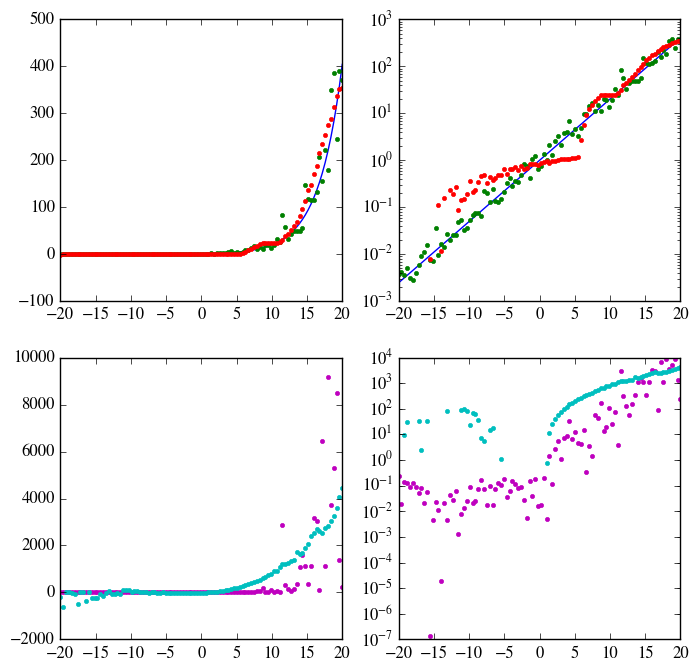

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].plot(truex, truey)
#ax[0].set_xlim(-xlim/4, xlim/4); ax[0].set_ylim(0, xlim*5); ax[0].grid(True)
ax[0][0].plot(shufx, shufrandy, 'g.')
ax[0][0].plot(shufx, pys, 'r.')

ax[0][1].plot(truex, truey)
#ax[1].grid(True) #ax[1].set_xlim(-xlim/4, xlim/4); ax[1].set_ylim(0, xlim*5); 
ax[0][1].plot(shufx, shufrandy, 'g.')
ax[0][1].plot(shufx, pys, 'r.')
ax[0][1].set_yscale("log")

# errors
#es = [py - f(shufx[i]) for i, py in enumerate(pys)]
es = [pow(py - shufrandy[i], 2) for i, py in enumerate(pys)]
ax[1][0].plot(shufx, es, 'm.');
ax[1][0].plot(shufx, pes, 'c.');
ax[1][1].plot(shufx, es, 'm.');
ax[1][1].plot(shufx, pes, 'c.');
ax[1][1].set_yscale("log")

#### Rank Everything

Ratios are the issue.  They are what create these exponential-like distributions.  But there's another way to deal with them: ratio-rank-linreg-derank-neutralize.  First take the ratio of 2 variables, then rank the ratio (which will be a uniformly distributed line), then derank (by selecting kNN in rank-space), then...?

Another idea: neutralize wrt the *sorted* y-variables (reassigned to different xs), which will have the same major axis as the originals, then pivot, then determine (minor axis) distance from major axis.  How to pivot: draw a line through the 25% and 75% of both, x and y, variables.

Another idea: fit a line to determine the major axis, then pivot, but then "unbend" the major axis so it lies flat.

This won't work with U-shaped relationships, but are those worth worrying about?

#### [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)

> Note that state-of-the-art deep learning libraries provide automatic differentiation that efficiently computes the gradient w.r.t. some parameters. If you derive the gradients yourself, then gradient checking is a good idea. (See here for some great tips on how to check gradients properly.)

So this suggests that the pieces of a process can be separated into two distinct classes, (1) those that generate the parameters, which are differentiable, and (2) those that are part of how the parameters behave (like trading costs and forecast uncertainty--"errors") which are not necessarily differentiable nor known in advance.  The latter are what are represented in the cost/loss/objective/reinforcement function.  But note that they can also be modeled with parameters and propagated into earlier parts of a "network," even if those parameters happen to be fixed they can still take part in those earlier derivatives.

#### Problem with piecewise learning

Are functions that are learned "piecewise"--like as with the above exponential curve--really "learned" at all?  Should we really consider one piece/segment of a function a "feature" of that function?  Would a coefficient in a polynomial be more (useful) of a feature or less?  (Update: A coefficient in a polynomial is at least a domain-global feature as opposed to a line used over only a portion of the domain.  This seems to be an inherrent limitation in neural nets which are made up of discrete, locally relevant nodes.  A Bayesian approach where every possible (global) function is assigned a probability might be the solution to avoiding such discrete-ness, which I suppose would be similar to the various terms of a polynomial which are themselves a series of functions.)

These features that are being considered here are really just different decompositions/deconstructions/representations of more complex functional forms/relationships.  The optimal "representational form" likely depends on the application.  Two different decompositions with the same order of complexity can have very different utility in different circumstances.  Recall the Banana Problem, and see "Partitioning based on input alone versus partitioning based on the input-output relationship" notes here: https://github.com/fcrimins/fcrimins.github.io/wiki/Notes-for-Geoff-Hinton%27s-Coursera-ML-course.

"For classification tasks, higher layers of representation amplify aspects of the input that are
important for discrimination and suppress irrelevant variations." [https://arxiv.org/pdf/1509.08627.pdf]

Also this: http://simplystatistics.org/2016/03/30/humans-as-training-set/